# Recommendation with SVD (_Singular Value Decomposition_)

In this notebook we will explore `FunkSVD`, a matrix factorization algorithm made famous in the [Netflix Prize Challenge](https://www.thrillist.com/entertainment/nation/the-netflix-prize) (2006). If you want to explore the implementation of the algorithm, visit [this repository](https://github.com/gbolmier/funk-svd).

**Note**: To install the `funk_svd` library, uncomment the line below and run the cell.

In [1]:
#!pip install git+https://github.com/gbolmier/funk-svd

In [2]:
import os
import re
import pandas as pd
import numpy as np
#from google.colab import files
from funk_svd import SVD
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

# Loading the dataset

In this practical example we will use `MovieLens`, a dataset that contains user reviews for films that was explored in module **01 - Introduction to Recommendation Systems**. In particular, we will load the following files:

- `ratings.parquet`: user ratings for films
- `movies.parquet`: movie metadata

## User reviews archive

Upload file `ratings.parquet`

In [3]:
import pyarrow.parquet as pq

In [4]:
df_ratings = pd.read_parquet('ratings.parquet')
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


## Item metadata file

Upload file `movies.parquet`

In [5]:
df_items = pd.read_parquet('movies.parquet')
df_items.tail()

,item_id,title,genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


# Pre-processing of data

In [6]:
def extract_year_from_title(title:str, regex='(\d{4})'):
    match = re.search(regex, title)
    return None if match is None else match.group()

def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items = pd.read_parquet('movies.parquet')
df_items['genres'] = df_items['genres'].apply(convert_genres_to_list)
df_items['year'] = df_items['title'].apply(extract_year_from_title)
df_items.set_index('item_id', inplace=True)
df_items.tail()

,title,genres,year
item_id,,,
3948,Meet the Parents (2000),[Comedy],2000
3949,Requiem for a Dream (2000),[Drama],2000
3950,Tigerland (2000),[Drama],2000
3951,Two Family House (2000),[Drama],2000
3952,"Contender, The (2000)","[Drama, Thriller]",2000


# Defining training and validation datasets

As FunkSVD is a model with trainable parameters, we can separate the dataset into training and validation to observe whether the training has good generalization.

Given the sequential nature of movie consumption, we will use the `timestamp` field to make the break between training and validation: the first `train_size` records will be used as training and the rest as testing.

Additionally, the `funk_svd` library requires the following column names:

- `u_id`: user identifier
- `i_id`: item identifier
- `rating`: user _feedback_

In [7]:
df_ratings.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
train_size = 0.8
df_ratings.sort_values(by='timestamp', inplace=True)
df_train_set, df_valid_set= np.split(df_ratings, [int(train_size * df_ratings.shape[0])])
df_train_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
df_valid_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
print ('Train size: ', df_train_set.shape)
print ('Valid size: ', df_valid_set.shape)

Train size:  (800167, 4)
Valid size:  (200042, 4)


# Training the model

For this practical example we will use hyperparameters already explored in the literature for the MovieLens dataset. However, for other datasets it is necessary to search for hyperparameters that are ideal for the data in question. To read the hyperparameter definition, see [documentation](https://github.com/gbolmier/funk-svd/blob/master/funk_svd/svd.py).

**Note**: To read more about hyperparameter testing, see the [HyperOpt](http://hyperopt.github.io/hyperopt/) library.

In [9]:
model = SVD(
    lr=0.001, # Learning rate.
    reg=0.005, # L2 regularization factor.
    n_epochs=100, # Number of SGD iterations.
    n_factors=30, # Number of latent factors.
    early_stopping=True, # Whether or not to stop training based on a validation monitoring.
    min_delta=0.0001, # Minimun delta to argue for an improvement.
    shuffle=False, # Whether or not to shuffle the training set before each epoch.
    min_rating=1, # Minimum value a rating should be clipped to at inference time.
    max_rating=5 # Maximum value a rating should be clipped to at inference time.
)
model

Training the model

In [10]:
model.fit(X=df_train_set, X_val=df_valid_set)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 1.1 sec
Epoch 2/100  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.1 sec
Epoch 3/100  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.1 sec
Epoch 4/100  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.1 sec
Epoch 5/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.77 - took 0.1 sec
Epoch 6/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 7/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 8/100  | val_loss: 0.93 - val_rmse: 0.97 - val_mae: 0.76 - took 0.1 sec
Epoch 9/100  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 10/100 | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 11/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 12/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 13/100 | val

# Evaluating training

To validate whether there was _overfitting_ or _underfitting_ we can plot the evolution of the training and validation metrics. In particular, the `funk_svd` library provides us with 3 training metrics:

- `Loss`: _Root Mean Squared Error_ (RMSE) to be optimized
- `MAE`: _Mean Absolute Error_ (MAE) of the validation set
- Validation Set `RMSE` _Root Mean Squared Error_

Extracting training metrics

In [11]:
model.metrics_

,Loss,RMSE,MAE
0,1.060575,1.029842,0.835089
1,1.008199,1.004091,0.805387
2,0.980960,0.990434,0.789730
3,0.964102,0.981887,0.780192
4,0.952601,0.976013,0.773788
...,...,...,...
64,0.889483,0.943124,0.742956
65,0.889277,0.943015,0.742903
66,0.889087,0.942914,0.742857
67,0.888914,0.942822,0.742818


(<Figure size 1600x800 with 1 Axes>,
 <AxesSubplot:title={'center':'SVD train and valid metrics (68 epochs)'}, xlabel='Epoch'>)

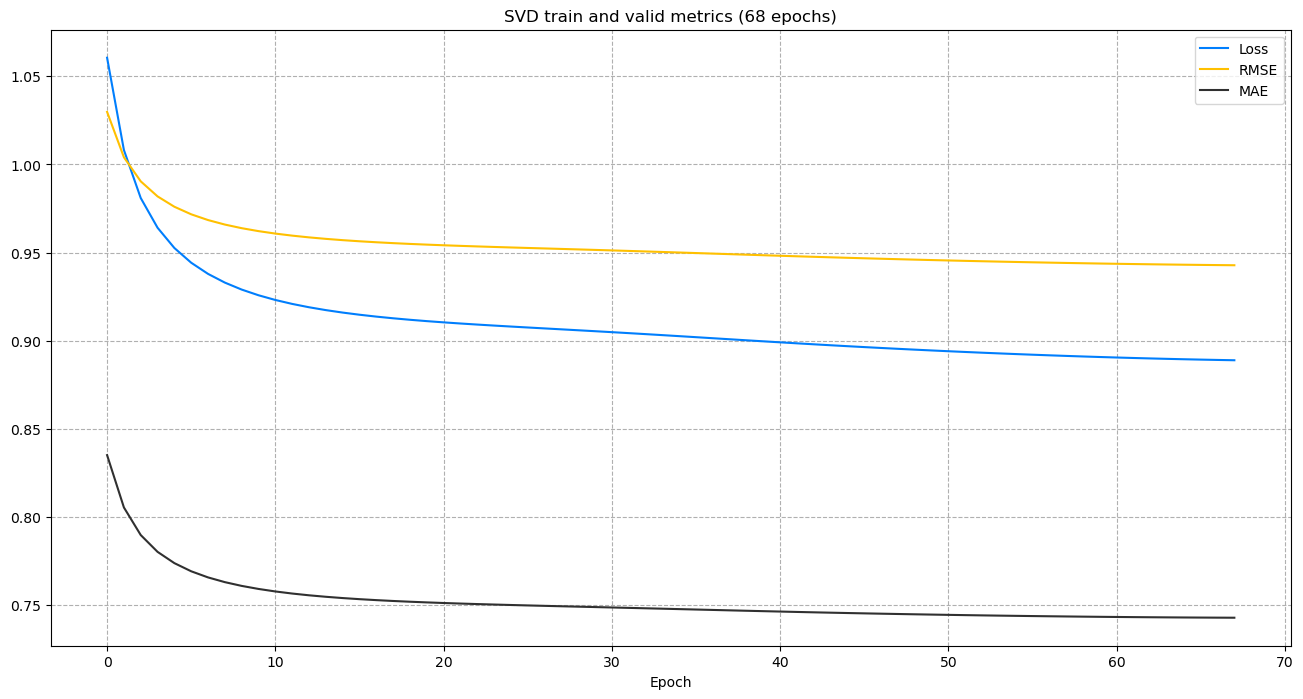

In [12]:
def plot_metrics_evolution(metrics:pd.DataFrame, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    for metric_name in metrics.columns:
        ax.plot(metrics[metric_name], label=metric_name)
    ax.set_title(f'SVD train and valid metrics ({metrics.shape[0]} epochs)')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, linestyle='--')

    return fig, ax

plot_metrics_evolution(model.metrics_.head(-1))

To predict user ratings for items, we can use the `mode.predict()` method for a batch of user-item pairs:

In [13]:
df_valid_set['prediction'] = model.predict(df_valid_set)
df_valid_set.head()

,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,4.232899
314032,1875,2621,4,975768748,3.744571
94555,635,3095,5,975768756,4.622151
94640,635,36,5,975768756,4.488622
94578,635,608,5,975768756,4.426846


Or we can make this prediction for a specific user-item pair using the `model.predict_pair()` method:

In [14]:
item_id = 1721
user_id = 1875

In [15]:
def get_user_item_prediction(model, user_id, item_id):
    prediction = model.predict_pair(user_id, item_id)
    return prediction

prediction = get_user_item_prediction(model, user_id, item_id)
print (f'Prediction for user {user_id} to item {item_id}: {prediction}')
df_valid_set.query('u_id == @user_id and i_id == @item_id')

Prediction for user 1875 to item 1721: 4.2328987879066435


,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,4.232899


________________________

# Generating recommendations

Once we have the model trained, we can use the `recommend_n_items` function below which receives:

- `model`: trained FunkSVD model
- `user_id`: identifier of the user who will receive the recommendations
- `item_ids`: identifiers of items in the catalog that can be recommended
- `n`: number of recommendations to be generated

In [16]:
def recommend_n_items(model, user_id, item_ids:np.array, n=20):
    df_predictions = pd.DataFrame()
    df_predictions['i_id'] = item_ids
    df_predictions['u_id'] = user_id
    df_predictions['score'] = model.predict(df_predictions)

    user_predictions = (
        df_predictions
        .sort_values(by='score', ascending=False)
        .rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
        .set_index('item_id')
    )

    return user_predictions.head(n)

item_ids = df_valid_set['i_id'].unique()
user_recommendations = recommend_n_items(model, user_id, item_ids, n=10)
user_recommendations

,user_id,score
item_id,,
527,1875,4.819725
858,1875,4.666856
912,1875,4.607358
923,1875,4.585422
2762,1875,4.518267
2905,1875,4.489217
1148,1875,4.462940
1207,1875,4.459536
922,1875,4.457972


Attaching the item metadata, we obtain:

In [17]:
user_recommendations.merge(df_items, left_index=True, right_index=True)

,user_id,score,title,genres,year
item_id,,,,,
527,1875,4.819725,Schindler's List (1993),"[Drama, War]",1993
858,1875,4.666856,"Godfather, The (1972)","[Action, Crime, Drama]",1972
912,1875,4.607358,Casablanca (1942),"[Drama, Romance, War]",1942
923,1875,4.585422,Citizen Kane (1941),[Drama],1941
2762,1875,4.518267,"Sixth Sense, The (1999)",[Thriller],1999
2905,1875,4.489217,Sanjuro (1962),"[Action, Adventure]",1962
1148,1875,4.462940,"Wrong Trousers, The (1993)","[Animation, Comedy]",1993
1207,1875,4.459536,To Kill a Mockingbird (1962),[Drama],1962
922,1875,4.457972,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),[Film-Noir],1950


Finally, run the cell below several times to generate recommendations from random users.

In [20]:
random_user_id = df_ratings['user_id'].sample().tolist()[0]
print (f'Recommendations for user {random_user_id}')
user_recommendations = recommend_n_items(model, random_user_id, item_ids, n=20)
user_recommendations.merge(df_items, left_index=True, right_index=True)

Recommendations for user 2873


,user_id,score,title,genres,year
item_id,,,,,
527,2873,4.656527,Schindler's List (1993),"[Drama, War]",1993
3753,2873,4.616512,"Patriot, The (2000)","[Action, Drama, War]",2000
356,2873,4.609507,Forrest Gump (1994),"[Comedy, Romance, War]",1994
920,2873,4.594999,Gone with the Wind (1939),"[Drama, Romance, War]",1939
590,2873,4.467711,Dances with Wolves (1990),"[Adventure, Drama, Western]",1990
1721,2873,4.459608,Titanic (1997),"[Drama, Romance]",1997
2762,2873,4.454161,"Sixth Sense, The (1999)",[Thriller],1999
2081,2873,4.410308,"Little Mermaid, The (1989)","[Animation, Children's, Comedy, Musical, Romance]",1989
919,2873,4.389215,"Wizard of Oz, The (1939)","[Adventure, Children's, Drama, Musical]",1939


__________________________

In [19]:
from tqdm import tqdm
model_name = 'svd'
n = 20
catalog = df_items.index.values
df_recommendations = pd.DataFrame()
for user_id in tqdm(df_valid_set['u_id'].unique()):
  user_known_items = df_train_set.query('u_id == @user_id')['i_id'].unique()
  recommendable_items = np.array(list(set(catalog)-set(user_known_items)))
  user_recommendations = recommend_n_items(model, user_id, recommendable_items, n).reset_index(drop=False)
  user_recommendations['user_id'] = user_id
  df_recommendations = pd.concat([df_recommendations, user_recommendations])

df_recommendations['y_score'] = df_recommendations.apply(lambda x: {'item_id': x['item_id'], 'score': x['score']}, axis=1)
df_recommendations = df_recommendations.groupby('user_id').agg({'y_score': list}).reset_index(drop=False)
df_recommendations.tail()


100%|██████████████████████████████████████████████████████████████████████████████| 1783/1783 [00:34<00:00, 51.24it/s]


,user_id,y_score
1778,6001,"[{'item_id': 2019.0, 'score': 4.71740742830154..."
1779,6002,"[{'item_id': 34.0, 'score': 5.0}, {'item_id': ..."
1780,6016,"[{'item_id': 3134.0, 'score': 4.45265030577080..."
1781,6028,"[{'item_id': 2905.0, 'score': 4.47571769489299..."
1782,6040,"[{'item_id': 3030.0, 'score': 4.54648581280122..."


In [21]:
df_predictions = df_valid_set.rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
df_predictions['y_true'] = df_predictions.apply(lambda x: {'item_id': x['item_id'], 'rating': x['rating']}, axis=1)
df_predictions = df_predictions.groupby('user_id').agg({'y_true': list}).reset_index(drop=False)
df_predictions = df_predictions.merge(df_recommendations, on='user_id', how='inner')
df_predictions['model'] = model_name
df_predictions.tail()

,user_id,y_true,y_score,model
1778,6001,"[{'item_id': 3751.0, 'rating': 4.0}, {'item_id...","[{'item_id': 2019.0, 'score': 4.71740742830154...",svd
1779,6002,"[{'item_id': 1942.0, 'rating': 5.0}, {'item_id...","[{'item_id': 34.0, 'score': 5.0}, {'item_id': ...",svd
1780,6016,"[{'item_id': 3756.0, 'rating': 3.0}, {'item_id...","[{'item_id': 3134.0, 'score': 4.45265030577080...",svd
1781,6028,"[{'item_id': 3000.0, 'rating': 4.0}]","[{'item_id': 2905.0, 'score': 4.47571769489299...",svd
1782,6040,"[{'item_id': 3182.0, 'rating': 5.0}, {'item_id...","[{'item_id': 3030.0, 'score': 4.54648581280122...",svd


In [22]:
column_order = ['model', 'user_id', 'y_true', 'y_score']
df_predictions[column_order].to_parquet(f'valid_{model_name}.parquet', index=None)